In [3]:
import torchvision
from torchvision import transforms
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torch.optim.lr_scheduler import CosineAnnealingLR

import numpy as np
import random
from tqdm import tqdm
from matplotlib import pyplot as plt
import os
import math
import logging
import time
import psutil
import pandas as pd

from view_transform import ViewTransform
from LARS import LARS

## Hyperparameters

In [ ]:
'''
TODO
-->> It might be interesting investigate the efficiency frontier between max_batch and views 
'''

In [ ]:
torch.manual_seed(42)
random.seed(42)

warmup_steps = 10 
epochs = 50 # Original set to 1000 
output_enc = 1000
dim = 8192
num_views = 4
offset = 1 

num_workers = 4
device = 'cuda' # or 'cuda' for faster training

batch_size = 2048

# VicREG
base_lr_ = 0.2
learning_rate = batch_size/256 * base_lr_ 
weight_decay = 1e-6

# BarlowTwins
# learning_rate = base_lr * batch_size / 256
# weight_decay = 1.5*1e-6

## Data 

In [ ]:
num_classes = 10

#trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)  
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)  
trainset.transform = ViewTransform(2)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

#linear_trainset = trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=linear_transform)  
#linear_trainset = trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=linear_transform)  
#linear_trainloader = torch.utils.data.DataLoader(linear_trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

#testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=linear_transform)  
#testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=linear_transform)  
#testset_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

## Model

In [ ]:
# encoder = torchvision.models.resnet18()
# encoder.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

def projector():
    proj_layers = []

    proj_layers.append(torch.nn.Linear(output_enc, dim))
    proj_layers.append(torch.nn.ReLU(dim))
    proj_layers.append(torch.nn.BatchNorm1d(dim))

    proj_layers.append(torch.nn.Linear(dim, dim))
    proj_layers.append(torch.nn.ReLU(dim))
    proj_layers.append(torch.nn.BatchNorm1d(dim))
    
    proj_layers.append(torch.nn.Linear(dim, dim, bias=False))
    
    return torch.nn.Sequential(*proj_layers)

## VicREG

In [ ]:
#VicReg Paper - with modifications
def VIC_Reg(Z):
    
    N = Z[0].shape[0]
    D = Z[0].shape[1]

    mu = 25
    la = 25
    nu = 1 
    
    sim_loss = 0
    std_loss = 0
    cov_loss = 0

    for i in range(len(Z)): 
        for j in range(i+1, len(Z)): 
            sim_loss += F.mse_loss(Z[i], Z[j])

    for zi in Z: 
        std_zi = torch.sqrt(zi.var(dim=0) + 1e-04)
        std_loss += torch.mean(torch.relu(1 - std_zi)) 
    
    for zi in Z: 
        zi = zi - zi.mean(dim=0)
        cov_zi = (zi.T @ zi) / (N - 1)
        cov_zi = cov_zi[~torch.eye(cov_zi.shape[0], dtype=bool)]
        cov_loss += cov_zi.pow_(2).sum() / D

    sim_loss /= (len(Z) * (len(Z)-1)) / 2
    std_loss /= len(Z)
    cov_loss /= len(Z)

    loss = la * sim_loss + mu * std_loss + nu * cov_loss
    
    return loss

In [ ]:
# Copied from https://github.com/facebookresearch/vicreg/blob/main/main_vicreg.py

def adjust_learning_rate(optimizer, loader, step):
    max_steps = epochs * len(loader)
    warmup_steps = 10 * len(loader)
    base_lr = base_lr_ * batch_size / 256
    if step < warmup_steps:
        lr = base_lr * step / warmup_steps
    else:
        step -= warmup_steps
        max_steps -= warmup_steps
        q = 0.5 * (1 + math.cos(math.pi * step / max_steps))
        end_lr = base_lr * 0.001
        lr = base_lr * q + end_lr * (1 - q)
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
    return lr

## Train

In [ ]:
def train(trainset, offset): 

    encoder = torchvision.models.resnet18() # also try with pretrained=true
    encoder.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

    rpoj = projector()
    model = torch.nn.Sequential(encoder, rpoj)

    model = model.to(device)
    model.train()
    optimizer = LARS(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay) 

    starttime = time.time()

    for i in range(epochs):
        losses = []
        for step, (X, _) in tqdm(enumerate(trainloader), total=epochs*len(trainloader)):
            
            if step % offset == 0: 
                lr = adjust_learning_rate(optimizer, trainloader, step)  
                optimizer.zero_grad()
            
            Z = []
            for xi in X: 
                xi = xi.to(device)
                Z.append(model(xi))
                
            loss = VIC_Reg(Z)
            logging.info('%s ,Epoch: %d, Step: %d, Loss: %.3f, Elapsed: %d, View: %d', time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())), i, step, loss, starttime-time.time(), len(Z))
            
            if step % offset == 0: 
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().item())


        print(f"Epoch: {i}, loss: {np.mean(losses)}")
        #DL 1 Homework 1 

        torch.save(encoder.state_dict(), f'models/VicReg/model_{len(Z)}_{batch_size}_epoch_{i}.pt')
    
    return encoder

encoder_vicreg = train(trainloader, offset)

In [ ]:
for i in range(2,num_views+1):
    print(f"View: {i} / {num_views}")
    view = i 
    at_limit = False

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)  
    trainset.transform = ViewTransform(view)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    
    os.makedirs('logs', exist_ok=True)
    os.makedirs('models', exist_ok=True)
    logging.basicConfig(filename=f'logs/b:{batch_size}.log', filemode='w', level=logging.INFO)
    logging.info('Epoch, Step, Loss, Elapsed, View')
    
    while True:
        try:
            if(at_limit):
                batch_size //= 2
                offset = offset * 2
                trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
                
            encoder_vicreg = train(trainloader, offset)
            break  #  successful break out of the loop
        except RuntimeError as e:
            if "out of memory" in str(e):
                print("Out of memory error occurred. Reducing batch size and retrying...")
                # Reduce batch size & Conversly increase step size
                batch_size //= 2
                offset = offset * 2
                at_limit = True

                trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
            else:
                raise e

In [82]:
df = pd.read_csv("logs/b_2048_v_2.log", delimiter=',', header=None)
columns = ["Info", "Epoch", "Step", "Loss", "Elapsed", "Views"]
df.columns = columns
df["Epoch"] = df["Epoch"].str.extract(r"(\d+)", expand=False).astype(int)
df["Step"] = df["Step"].str.extract(r"(\d+)", expand=False).astype(int)
df["Loss"] = df["Loss"].str.extract(r"(\d+\.\d+)", expand=False).astype(float)
df["Elapsed"] = df["Elapsed"].str.extract(r"(\d+)", expand=False).astype(float)
df["Views"] = df["Views"].str.extract(r"(\d+)", expand=False).astype(int)

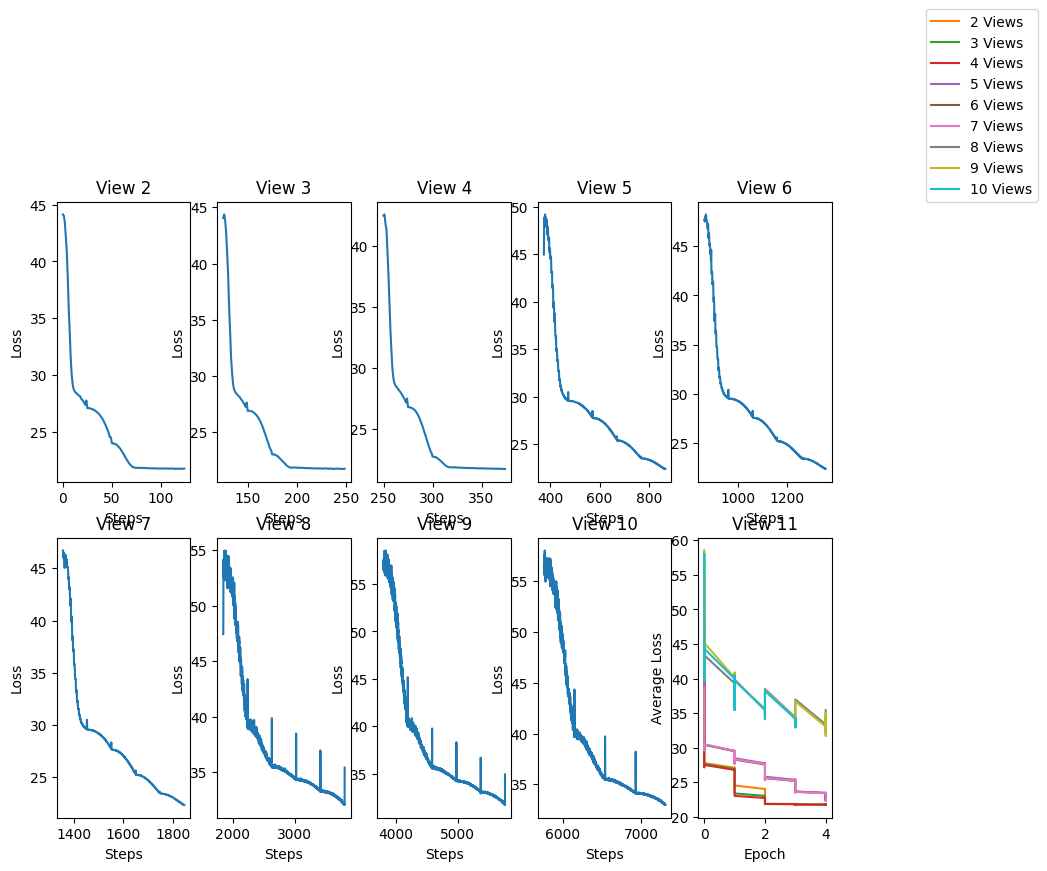

In [114]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 8))

for i, ax in enumerate(axes.flatten()):
    grouped_data = df[df["Views"] == i+2]
    #grouped_data = grouped_data.groupby("Epoch").agg({"Loss": "mean"}).reset_index()
    ax.plot(grouped_data["Loss"])
    ax.set_xlabel("Steps")
    ax.set_ylabel("Loss")
    ax.set_title(f"View {i+2}")

for i in range(2,num_views+1): 
    grouped_data = df[df["Views"] == i]
    #grouped_data.groupby("Epoch").agg({"Loss": "mean"}).reset_index()
    ax.plot(grouped_data["Epoch"], grouped_data["Loss"],label=f"{i} Views")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Average Loss")


# Get the handles and labels from the plots
handles, labels = ax.get_legend_handles_labels()

# Place the legend outside the plot
plt.figlegend(handles, labels, loc='center', bbox_to_anchor=(1.05, 1))

plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.show()


In [112]:
for view in range(2,num_views+1):
    last_loss = df[df["Views"] == view]["Loss"].tail(1).values[0]
    print(f"Last loss for View {view}: {last_loss}")

Last loss for View 2: 21.793
Last loss for View 3: 21.765
Last loss for View 4: 21.716
Last loss for View 5: 22.376
Last loss for View 6: 22.404
Last loss for View 7: 22.342
Last loss for View 8: 35.431
Last loss for View 9: 34.939
Last loss for View 10: 32.999
